# **Librerias**

In [1]:
# Importamos

import jax
import torch
import matplotlib
import torchvision
import jax.numpy as jaxnp
import matplotlib.pyplot as plt

from torch import nn
from torch.optim import SGD
from torchvision.datasets import MNIST
from torch.nn.functional import relu, softmax
from torch.utils.data import Dataset, DataLoader

# Version 

print(f'JAX Version: {jax.__version__}')
print(f'Pytorch Version: {torch.__version__}')
print(f'Matplotlib Version: {matplotlib.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')

JAX Version: 0.4.34
Pytorch Version: 2.5.1+cpu
Matplotlib Version: 3.9.2
Torchvision Version: 0.20.1+cpu


# **Dataset**

In [2]:
# Descargamos el Dataset

train_raw_dataset = MNIST(root = '../datasets/Pytorch_MNIST/', train = True, download = True)
valid_raw_dataset = MNIST(root = '../datasets/Pytorch_MNIST/', train = False, download = True)

# Seleccionamos las Imagenes y las Etiquetas de cada conjunto de datos 

train_images = train_raw_dataset.data 
train_labels = train_raw_dataset.targets 

valid_images = valid_raw_dataset.data 
valid_labels = valid_raw_dataset.targets 

# Definimos el Dataset Pesonalizado (Normalizamos y Aplanamos las Imagenes)

class CustomDataset(Dataset): 
    
    def __init__(self, images, labels): 
        
        self.images = images  
        self.labels = labels
        
    def __len__(self):
        return len(self.images) 
    
    def __getitem__(self, idx):
        
        image = self.images[idx] 
        image = image / 255.0 
        image = image.view(-1)
        
        label = self.labels[idx]
        
        return image, label
        
train_dataset = CustomDataset(images = train_images, labels = train_labels)       
valid_dataset = CustomDataset(images = valid_images, labels = valid_labels)     

# Definimos el Cargador de Datos

train_dataloader = DataLoader(dataset = train_dataset, batch_size = 16, shuffle = False, drop_last = True)
valid_dataloader = DataLoader(dataset = valid_dataset, batch_size = 16, shuffle = False, drop_last = True)

# Visualizamos

for batch in train_dataloader:
    
    print(f'Dimension Batch de Imagenes: {batch[0].shape}')
    print(f'Dimension Batch de Etiquetas: {batch[1].shape}\n')
    print(f'Batch de Imagenes: \n{batch[0]}\n')
    print(f'Batch de Etiquetas: \n{batch[1]}')
    
    break

Dimension Batch de Imagenes: torch.Size([16, 784])
Dimension Batch de Etiquetas: torch.Size([16])

Batch de Imagenes: 
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Batch de Etiquetas: 
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7])


# **Arquitectura de Red Neuronal**

In [3]:
# Definimos la Semilla

key = jax.random.PRNGKey(42)

# Definimos la Capa Lineal Inicializada con el Metodo Xavier

def linear_xavier_normal(in_features, out_features): 
       
    xavier = 2 / (in_features + out_features) 
    
    std = jaxnp.sqrt(xavier)  
    
    layer = jax.random.normal(key = key, shape = (in_features, out_features)) * std
    
    return layer  

# Definimos la Inicializacion de los Parametros de la Red Neuronal

def initializer_NN(input_dim, hidden_dim, output_dim): 
    
    W1 = linear_xavier_normal(in_features = input_dim, out_features = hidden_dim)
    W2 = linear_xavier_normal(in_features = hidden_dim, out_features = 2 * hidden_dim)
    W3 = linear_xavier_normal(in_features = 2 * hidden_dim, out_features = 4 * hidden_dim)
    W4 = linear_xavier_normal(in_features = 4 * hidden_dim, out_features = 2 * hidden_dim)
    W5 = linear_xavier_normal(in_features = 2 * hidden_dim, out_features = output_dim)
    
    b1 = jaxnp.ones(shape = (1, W1.shape[1]))
    b2 = jaxnp.ones(shape = (1, W2.shape[1]))
    b3 = jaxnp.ones(shape = (1, W3.shape[1]))
    b4 = jaxnp.ones(shape = (1, W4.shape[1]))
    b5 = jaxnp.ones(shape = (1, W5.shape[1]))
    
    init_params = W1, b1, W2, b2, W3, b3, W4, b4, W5, b5
        
    return init_params

# Visualizamos 

params = initializer_NN(input_dim = 784, hidden_dim = 64, output_dim = 10) 

for layer_id, idx in enumerate(range(0, len(params), 2)):
    print(f'Capa Lineal #{layer_id+1}')
    print(f'Dimension de los Pesos: {params[idx].shape}')
    print(f'Dimension de los Sesgos: {params[idx+1].shape}\n')

Capa Lineal #1
Dimension de los Pesos: (784, 64)
Dimension de los Sesgos: (1, 64)

Capa Lineal #2
Dimension de los Pesos: (64, 128)
Dimension de los Sesgos: (1, 128)

Capa Lineal #3
Dimension de los Pesos: (128, 256)
Dimension de los Sesgos: (1, 256)

Capa Lineal #4
Dimension de los Pesos: (256, 128)
Dimension de los Sesgos: (1, 128)

Capa Lineal #5
Dimension de los Pesos: (128, 10)
Dimension de los Sesgos: (1, 10)



# **Manual**

### **Forward**

In [4]:
# Definimos la Funcion Forward

def jax_forward(inputs, params): 
    
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = params 
             
    Z1 = jaxnp.matmul(inputs, W1) + b1 
    A1 = jax.nn.relu(Z1)
    Z2 = jaxnp.matmul(A1, W2) + b2 
    A2 = jax.nn.relu(Z2)
    Z3 = jaxnp.matmul(A2, W3) + b3 
    A3 = jax.nn.relu(Z3)
    Z4 = jaxnp.matmul(A3, W4) + b4 
    A4 = jax.nn.relu(Z4)
    Z5 = jaxnp.matmul(A4, W5) + b5 
    
    outputs = Z1, A1, Z2, A2, Z3, A3, Z4, A4, Z5
       
    return outputs

# Definimos la Funcion de Perdidas 

def jax_loss_Fn(inputs, labels, params):
    
    outputs = jax_forward(inputs, params) 
     
    logits = outputs[-1] 
    logits = jax.nn.log_softmax(logits)   
    
    labels_one_hot = jax.nn.one_hot(labels, num_classes = logits.shape[-1])
   
    loss = - jaxnp.mean(jaxnp.sum(logits * labels_one_hot, axis = -1))
        
    return loss

# Definimos la Funcion de Precision 

def jax_accuracy(outputs, labels):
    
    logits = outputs[-1]
    logits = jax.nn.softmax(logits) 
    logits = jaxnp.argmax(logits, axis = -1, keepdims = True)
    
    accuracy = jaxnp.mean(logits == labels)
    
    return accuracy

# Definimos el Calculo de Gradientes 

def grads_hand(inputs, outputs, labels, params):
    
    logits = outputs[-1]
    logits = jax.nn.softmax(logits)
    
    labels_one_hot = jax.nn.one_hot(labels, num_classes = logits.shape[-1])
    
    loss_derivate = logits - labels_one_hot
    
    accum_grad = loss_derivate
        
    grads = []    
    
    for param_idx in reversed(range(0, len(params) // 2)):     
        
        input_activation = outputs[(2 * param_idx) - 1] if param_idx > 0 else inputs
        
        dW = jaxnp.matmul(input_activation.T, accum_grad) / inputs.shape[0]
        dB = jaxnp.mean(accum_grad, axis = 0, keepdims = True)

        grads.insert(0, dB)
        grads.insert(0, dW) 
        
        if param_idx > 0:
            accum_grad = jaxnp.matmul(params[(2 * param_idx)], accum_grad.T).T * (outputs[((2 * param_idx) - 1)] > 0)
            
    return grads

# Definimos la Actualizacion de Gradientes 

def update_grads(params, grads, lr):
    
    new_params = [param - (lr * grad) for param, grad in zip(params, grads)]
    
    return new_params

### **Entrenamiento**

In [5]:
# Incializamos los Parametros 

params = initializer_NN(input_dim = 784, hidden_dim = 64, output_dim = 10) 

# Definimos los Hiperparametros 

lr = 0.001
epochs = 10 

# Bucle de Entrenamiento 

train_losses = [] 
valid_losses = [] 

train_accuracies = []
valid_accuracies = []

for epoch in range(0, epochs): 
       
    train_batch_losses = [] 
    train_batch_accuracy = []
    
    for batch in train_dataloader:
        
        inputs, labels = batch
        
        inputs = jaxnp.array(inputs.cpu().detach().numpy())    
        labels = jaxnp.array(labels.cpu().detach().numpy()) 
        
        outputs = jax_forward(inputs, params)
               
        train_loss = jax_loss_Fn(inputs, labels, params)
        train_accuracy = jax_accuracy(outputs, labels)
        
        grads = grads_hand(inputs, outputs, labels, params)
        params = update_grads(params, grads, lr)            
      
        train_batch_losses.append(train_loss)
        train_batch_accuracy.append(train_accuracy)        
    
    valid_batch_losses = [] 
    valid_batch_accuracy = []
        
    for batch in valid_dataloader:
        
        inputs, labels = batch
        
        inputs = jaxnp.array(inputs.cpu().detach().numpy())    
        labels = jaxnp.array(labels.cpu().detach().numpy()) 
               
        outputs = jax_forward(inputs, params)   
        
        valid_loss = jax_loss_Fn(inputs, labels, params)
        valid_accuracy = jax_accuracy(outputs, labels)
        
        valid_batch_losses.append(valid_loss)
        valid_batch_accuracy.append(valid_accuracy)
        
    train_batch_losses = jaxnp.array(train_batch_losses)
    valid_batch_losses = jaxnp.array(valid_batch_losses)
    train_batch_accuracy = jaxnp.array(train_batch_accuracy)
    valid_batch_accuracy = jaxnp.array(valid_batch_accuracy)
        
    train_losses.append(train_batch_losses.mean())
    valid_losses.append(valid_batch_losses.mean())    
    train_accuracies.append(train_batch_accuracy.mean())
    valid_accuracies.append(valid_batch_accuracy.mean())
        
    print(f'Epoch {epoch+1}:')
    print(f'Training Loss: {train_losses[-1]: 0.4f}, Training Accuracy: {train_accuracies[-1]: 0.4f}')
    print(f'Validation Loss: {valid_losses[-1]: 0.4f}, Validation Accuracy: {valid_accuracies[-1]: 0.4f}\n') 

Epoch 1:
Training Loss:  1.0090, Training Accuracy:  0.1347
Validation Loss:  0.5091, Validation Accuracy:  0.1397

Epoch 2:
Training Loss:  0.4294, Training Accuracy:  0.1431
Validation Loss:  0.3816, Validation Accuracy:  0.1418

Epoch 3:
Training Loss:  0.3562, Training Accuracy:  0.1441
Validation Loss:  0.3333, Validation Accuracy:  0.1428

Epoch 4:
Training Loss:  0.3213, Training Accuracy:  0.1447
Validation Loss:  0.3052, Validation Accuracy:  0.1433

Epoch 5:
Training Loss:  0.2983, Training Accuracy:  0.1451
Validation Loss:  0.2858, Validation Accuracy:  0.1437

Epoch 6:
Training Loss:  0.2807, Training Accuracy:  0.1454
Validation Loss:  0.2705, Validation Accuracy:  0.1441

Epoch 7:
Training Loss:  0.2663, Training Accuracy:  0.1457
Validation Loss:  0.2578, Validation Accuracy:  0.1443

Epoch 8:
Training Loss:  0.2538, Training Accuracy:  0.1459
Validation Loss:  0.2471, Validation Accuracy:  0.1445

Epoch 9:
Training Loss:  0.2427, Training Accuracy:  0.1461
Validation L

### **Visualizacion**

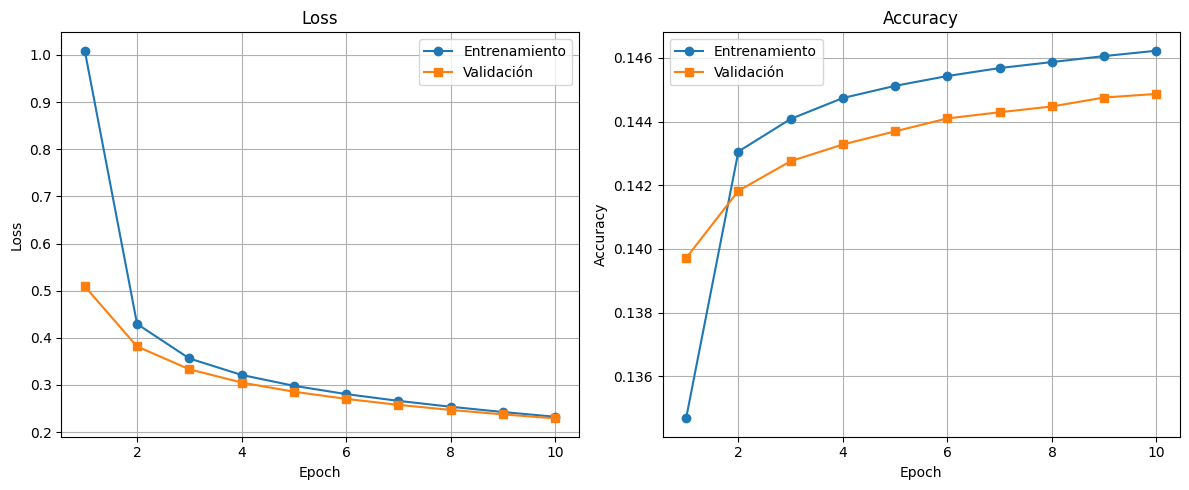

In [6]:
# Visualizacion 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(range(1, len(train_losses) + 1), train_losses, label = 'Entrenamiento', marker = 'o')
axes[0].plot(range(1, len(valid_losses) + 1), valid_losses, label = 'Validación', marker = 's')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label = 'Entrenamiento', marker = 'o')
axes[1].plot(range(1, len(valid_accuracies) + 1), valid_accuracies, label = 'Validación', marker = 's')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# **JAX**

### **Forward**

In [7]:
# Definimos la Funcion Forward

def jax_forward(inputs, params): 
    
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = params  
             
    X = jaxnp.matmul(inputs, W1) + b1 
    X = jax.nn.relu(X)
    X = jaxnp.matmul(X, W2) + b2 
    X = jax.nn.relu(X)
    X = jaxnp.matmul(X, W3) + b3 
    X = jax.nn.relu(X)
    X = jaxnp.matmul(X, W4) + b4 
    X = jax.nn.relu(X)
    X = jaxnp.matmul(X, W5) + b5      
    
    return X

# Definimos la Funcion de Perdidas 

def jax_loss_Fn(inputs, labels, params):
    
    logits = jax_forward(inputs, params)  
    logits = jax.nn.log_softmax(logits)    
    
    labels_one_hot = jax.nn.one_hot(labels, num_classes = logits.shape[-1])
   
    loss = - jaxnp.mean(jaxnp.sum(logits * labels_one_hot, axis = -1))
        
    return loss

# Definimos la Funcion de Precision 

def jax_accuracy(logits, labels):
    
    logits = jax.nn.softmax(logits, axis = -1) 
    logits = jaxnp.argmax(logits, axis = -1, keepdims = True)
    
    accuracy = jaxnp.mean(logits == labels)
    
    return accuracy

# Definimos el Calculo de Gradientes 

def jax_grads(inputs, labels, params): 
    
    grads = jax.grad(jax_loss_Fn, argnums = -1)(inputs, labels, params) 
    
    return grads

# Definimos la Actualizacion de Gradientes 

def update_grads(params, grads, lr):
    
    new_params = [param - (lr * grad) for param, grad in zip(params, grads)]
    
    return new_params

### **Entrenamiento**

In [8]:
# Incializamos los Parametros 

params = initializer_NN(input_dim = 784, hidden_dim = 64, output_dim = 10) 

# Definimos los Hiperparametros 

lr = 0.001
epochs = 10 

# Bucle de Entrenamiento 

train_losses = [] 
valid_losses = [] 

train_accuracies = []
valid_accuracies = []

for epoch in range(0, epochs): 
       
    train_batch_losses = [] 
    train_batch_accuracy = []
    
    for batch in train_dataloader:
        
        inputs, labels = batch
        
        inputs = jaxnp.array(inputs.cpu().detach().numpy())    
        labels = jaxnp.array(labels.cpu().detach().numpy()) 
        
        train_logits = jax_forward(inputs, params)
        
        train_loss = jax_loss_Fn(inputs, labels, params)
        train_accuracy = jax_accuracy(train_logits, labels)
        
        grads = jax_grads(inputs, labels, params) 
        params = update_grads(params, grads, lr)            
      
        train_batch_losses.append(train_loss)
        train_batch_accuracy.append(train_accuracy)        
    
    valid_batch_losses = [] 
    valid_batch_accuracy = []
        
    for batch in valid_dataloader:
        
        inputs, labels = batch
        
        inputs = jaxnp.array(inputs.cpu().detach().numpy())    
        labels = jaxnp.array(labels.cpu().detach().numpy()) 
               
        valid_logits = jax_forward(inputs, params)      
        
        valid_loss = jax_loss_Fn(inputs, labels, params)
        valid_accuracy = jax_accuracy(valid_logits, labels)
        
        valid_batch_losses.append(valid_loss)
        valid_batch_accuracy.append(valid_accuracy)
        
    train_batch_losses = jaxnp.array(train_batch_losses)
    valid_batch_losses = jaxnp.array(valid_batch_losses)
    train_batch_accuracy = jaxnp.array(train_batch_accuracy)
    valid_batch_accuracy = jaxnp.array(valid_batch_accuracy)
        
    train_losses.append(train_batch_losses.mean())
    valid_losses.append(valid_batch_losses.mean())    
    train_accuracies.append(train_batch_accuracy.mean())
    valid_accuracies.append(valid_batch_accuracy.mean())
        
    print(f'Epoch {epoch+1}:')
    print(f'Training Loss: {train_losses[-1]: 0.4f}, Training Accuracy: {train_accuracies[-1]: 0.4f}')
    print(f'Validation Loss: {valid_losses[-1]: 0.4f}, Validation Accuracy: {valid_accuracies[-1]: 0.4f}\n') 

Epoch 1:
Training Loss:  1.0090, Training Accuracy:  0.1347
Validation Loss:  0.5090, Validation Accuracy:  0.1397

Epoch 2:
Training Loss:  0.4294, Training Accuracy:  0.1431
Validation Loss:  0.3816, Validation Accuracy:  0.1418

Epoch 3:
Training Loss:  0.3562, Training Accuracy:  0.1441
Validation Loss:  0.3334, Validation Accuracy:  0.1427

Epoch 4:
Training Loss:  0.3213, Training Accuracy:  0.1447
Validation Loss:  0.3051, Validation Accuracy:  0.1433

Epoch 5:
Training Loss:  0.2982, Training Accuracy:  0.1451
Validation Loss:  0.2856, Validation Accuracy:  0.1437

Epoch 6:
Training Loss:  0.2807, Training Accuracy:  0.1454
Validation Loss:  0.2705, Validation Accuracy:  0.1441

Epoch 7:
Training Loss:  0.2663, Training Accuracy:  0.1457
Validation Loss:  0.2579, Validation Accuracy:  0.1443

Epoch 8:
Training Loss:  0.2538, Training Accuracy:  0.1459
Validation Loss:  0.2471, Validation Accuracy:  0.1445

Epoch 9:
Training Loss:  0.2426, Training Accuracy:  0.1460
Validation L

### **Visualizacion**

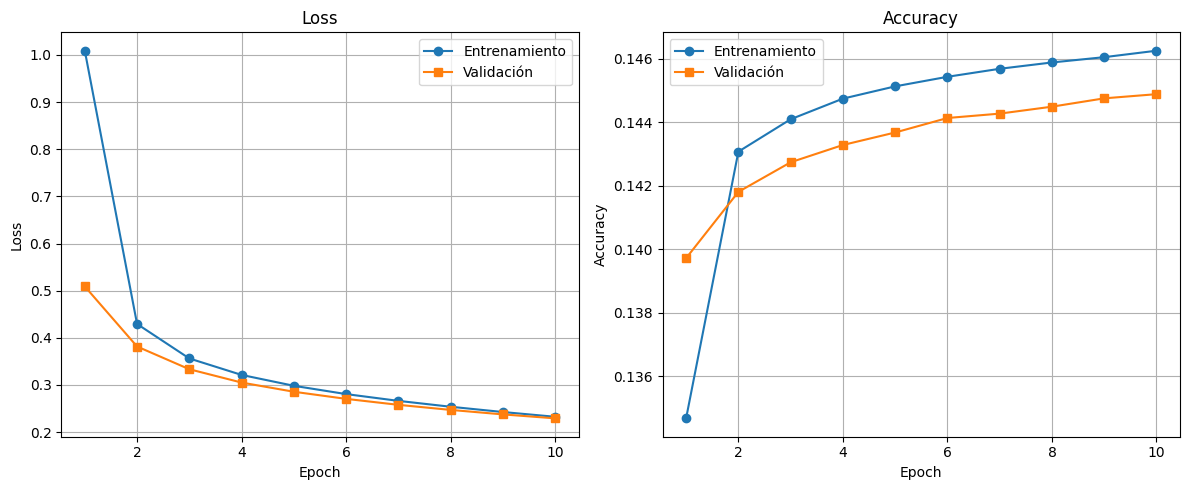

In [9]:
# Visualizacion 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(range(1, len(train_losses) + 1), train_losses, label = 'Entrenamiento', marker = 'o')
axes[0].plot(range(1, len(valid_losses) + 1), valid_losses, label = 'Validación', marker = 's')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label = 'Entrenamiento', marker = 'o')
axes[1].plot(range(1, len(valid_accuracies) + 1), valid_accuracies, label = 'Validación', marker = 's')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# **Pytorch**

### **Forward**

In [10]:
# Definimos la Funcion para Transformar los Parametros de JAX a Pytorch 

def pytorch_params(params):
    
    torch_params = [torch.tensor(param.tolist(), requires_grad = True) for param in params]
    
    return torch_params 

# Definimos la Funcion Forward

def torch_forward(inputs, params): 
    
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = params  
             
    X = torch.matmul(inputs, W1) + b1 
    X = relu(X)
    X = torch.matmul(X, W2) + b2 
    X = relu(X)
    X = torch.matmul(X, W3) + b3 
    X = relu(X)
    X = torch.matmul(X, W4) + b4 
    X = relu(X)
    X = torch.matmul(X, W5) + b5      
    
    return X

# Definimos la Funcion de Precision 

def torch_accuracy(logits, labels):
    
    logits = softmax(logits, dim = -1)
    logits = torch.argmax(logits, dim = -1, keepdim = True)
       
    accuracy = torch.mean((logits == labels).float())
    
    return accuracy

### **Entrenamiento**

In [11]:
# Incializamos los Parametros 

params = initializer_NN(input_dim = 784, hidden_dim = 64, output_dim = 10) 

# Convertimos los Parametros desde JAX a Pytorch 

torch_params = pytorch_params(params)

# Definimos la Funcion de Perdida 

loss_Fn = nn.CrossEntropyLoss() 

# Definimos el Optimizador

optimizer = SGD(params = torch_params, lr = 0.001)

# Definimos los Hiperparametros 

epochs = 10 

# Bucle de Entrenamiento 

train_losses = [] 
valid_losses = [] 

train_accuracies = []
valid_accuracies = []

for epoch in range(0, epochs): 
       
    train_batch_losses = [] 
    train_batch_accuracy = []
    
    for batch in train_dataloader:
        
        inputs, labels = batch
        
        optimizer.zero_grad()
        
        train_logits = torch_forward(inputs, torch_params)
        
        train_loss = loss_Fn(train_logits, labels)        
        train_accuracy = torch_accuracy(train_logits, labels)
        
        train_loss.backward()
        optimizer.step() 
        
        train_batch_losses.append(train_loss.item())
        train_batch_accuracy.append(train_accuracy.item())
        
    valid_batch_losses = [] 
    valid_batch_accuracy = []
    
    for batch in valid_dataloader:
        
        inputs, labels = batch
               
        valid_logits = torch_forward(inputs, torch_params)
        
        valid_loss = loss_Fn(valid_logits, labels)       
        valid_accuracy = torch_accuracy(valid_logits, labels)
        
        valid_batch_losses.append(valid_loss.item())
        valid_batch_accuracy.append(valid_accuracy.item())
        
    train_batch_losses = jaxnp.array(train_batch_losses)
    valid_batch_losses = jaxnp.array(valid_batch_losses)
    train_batch_accuracy = jaxnp.array(train_batch_accuracy)
    valid_batch_accuracy = jaxnp.array(valid_batch_accuracy)
        
    train_losses.append(train_batch_losses.mean())
    valid_losses.append(valid_batch_losses.mean())
    
    train_accuracies.append(train_batch_accuracy.mean())
    valid_accuracies.append(valid_batch_accuracy.mean())
        
    print(f'Epoch {epoch+1}:')
    print(f'Training Loss: {train_losses[-1]: 0.4f}, Training Accuracy: {train_accuracies[-1]: 0.4f}')
    print(f'Validation Loss: {valid_losses[-1]: 0.4f}, Validation Accuracy: {valid_accuracies[-1]: 0.4f}\n')     

Epoch 1:
Training Loss:  1.0090, Training Accuracy:  0.1347
Validation Loss:  0.5090, Validation Accuracy:  0.1397

Epoch 2:
Training Loss:  0.4294, Training Accuracy:  0.1431
Validation Loss:  0.3816, Validation Accuracy:  0.1418

Epoch 3:
Training Loss:  0.3562, Training Accuracy:  0.1441
Validation Loss:  0.3333, Validation Accuracy:  0.1427

Epoch 4:
Training Loss:  0.3213, Training Accuracy:  0.1447
Validation Loss:  0.3052, Validation Accuracy:  0.1433

Epoch 5:
Training Loss:  0.2982, Training Accuracy:  0.1451
Validation Loss:  0.2857, Validation Accuracy:  0.1437

Epoch 6:
Training Loss:  0.2806, Training Accuracy:  0.1454
Validation Loss:  0.2704, Validation Accuracy:  0.1441

Epoch 7:
Training Loss:  0.2663, Training Accuracy:  0.1457
Validation Loss:  0.2578, Validation Accuracy:  0.1443

Epoch 8:
Training Loss:  0.2538, Training Accuracy:  0.1459
Validation Loss:  0.2471, Validation Accuracy:  0.1445

Epoch 9:
Training Loss:  0.2426, Training Accuracy:  0.1460
Validation L

### **Visualizacion**

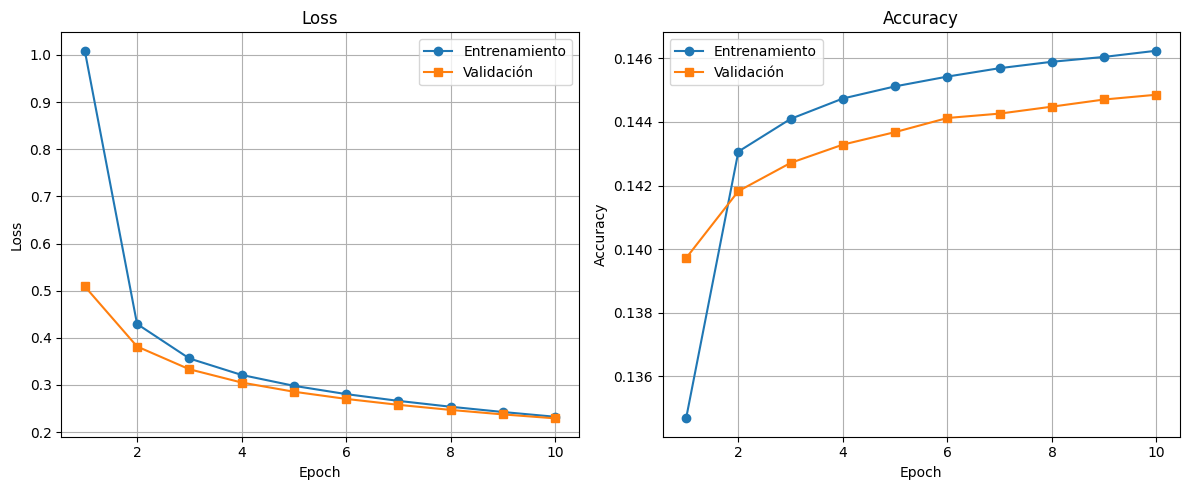

In [12]:
# Visualizacion 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(range(1, len(train_losses) + 1), train_losses, label = 'Entrenamiento', marker = 'o')
axes[0].plot(range(1, len(valid_losses) + 1), valid_losses, label = 'Validación', marker = 's')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label = 'Entrenamiento', marker = 'o')
axes[1].plot(range(1, len(valid_accuracies) + 1), valid_accuracies, label = 'Validación', marker = 's')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()